In [47]:
# === 📦 LIBRERIE BASE ===
import gymnasium as gym
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
import json
import pandas as pd


In [48]:
# === ⚙️ CONFIGURAZIONI GLOBALI ===
ENV_NAME = "LunarLander-v3"
SEED = 42

# Imposta i semi per riproducibilità
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

# Cartelle di output
BASE_DIR = "experiments/lunarlander"
RESULTS_DIR = os.path.join(BASE_DIR, "results")
MODELS_DIR = os.path.join(BASE_DIR, "models")
PLOTS_DIR = os.path.join(BASE_DIR, "plots")
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)

# Parametri DQN
config = {
    "episodes": 400,
    "max_steps": 1000,
    "gamma": 0.99,
    "learning_rate": 1e-3,
    "batch_size": 64,
    "buffer_size": 100_000,
    "min_buffer": 10_000,
    "update_target_every": 1000,
    "epsilon_start": 1.0,
    "epsilon_end": 0.05,
    "epsilon_decay": 0.995,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
}

print(f"✅ Configurazione ambiente completata su device: {config['device']}")


✅ Configurazione ambiente completata su device: cpu


In [49]:
# === 🎮 AMBIENTE ===
env = gym.make(ENV_NAME)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

print(f"Ambiente: {ENV_NAME}")
print(f"Dimensione stato: {state_dim}")
print(f"Numero azioni: {action_dim}")


Ambiente: LunarLander-v3
Dimensione stato: 8
Numero azioni: 4


In [50]:
# === 🧠 FUNZIONI DI SUPPORTO ===
def plot_rewards(rewards, title="Reward per episodio"):
    plt.figure(figsize=(10,5))
    plt.plot(rewards, label="Reward")
    plt.xlabel("Episodi")
    plt.ylabel("Reward totale")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()

def save_results_csv(rewards, filename):
    df = pd.DataFrame({"episode": np.arange(len(rewards)), "reward": rewards})
    path = os.path.join(RESULTS_DIR, filename)
    df.to_csv(path, index=False)
    print(f"💾 Salvato: {path}")

def save_model(model, filename):
    path = os.path.join(MODELS_DIR, filename)
    torch.save(model.state_dict(), path)
    print(f"🧠 Modello salvato: {path}") 


# === 🎥 Registrazione multipla di episodi ordinati per reward ===
import os, json, torch, imageio, numpy as np
import gymnasium as gym

# === 🎥 Registrazione multipla di episodi (robusta + compatibile FFmpeg) ===
import os, json, torch, imageio, numpy as np
import gymnasium as gym

# === 🎥 VIDEO RECORDING PROGRESSIVO DA CHECKPOINTS ===
import imageio, json, torch, numpy as np
import gymnasium as gym

import os, json, torch, imageio
from tqdm import tqdm

def record_learning_progress(
    algo_name,
    env_name="LunarLander-v3",
    checkpoints_dir="experiments/lunarlander/models",
    out_dir="experiments/lunarlander/static/videos",
    device="cpu",
    fps=30
):
    """
    Registra video per i checkpoint di training per mostrare visivamente
    come l'agente impara nel tempo (dai crash ai touchdown perfetti 🚀).
    Compatibile con DQN, Double DQN, Dueling DQN e DQN + PER.
    """

    os.makedirs(out_dir, exist_ok=True)
    env = gym.make(env_name, render_mode="rgb_array")
    device = torch.device(device)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    # === Selezione automatica rete ===
    if "duel" in algo_name.lower():
        print("⚙️ Inizializzo rete: DuelingQNetwork")
        model = DuelingQNetwork(state_dim, action_dim).to(device)
    else:
        print("⚙️ Inizializzo rete: QNetwork (classico, double o PER)")
        model = QNetwork(state_dim, action_dim).to(device)

    # === Trova checkpoint ===
    checkpoints = sorted([
        os.path.join(checkpoints_dir, f)
        for f in os.listdir(checkpoints_dir)
        if f.startswith(algo_name) and f.endswith(".pth")
    ])
    if not checkpoints:
        print(f"⚠️ Nessun checkpoint trovato per {algo_name} in {checkpoints_dir}")
        return

    print(f"🎬 Registrazione progressiva per {algo_name.upper()} — {len(checkpoints)} checkpoint trovati")
    results = []

    for ckpt_path in tqdm(checkpoints, desc=f"Registrazione {algo_name}", ncols=90):
        base = os.path.basename(ckpt_path)
        digits = ''.join(filter(str.isdigit, base))
        ep_num = int(digits) if digits else 0

        try:
            model.load_state_dict(torch.load(ckpt_path, map_location=device))
        except Exception as e:
            print(f"❌ Errore nel caricamento di {base}: {e}")
            continue

        model.eval()
        frames, total_reward = [], 0.0
        state, _ = env.reset(seed=42 + ep_num)
        done = False

        while not done:
            s = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
            with torch.no_grad():
                action = model(s).argmax().item()
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward

            frame = env.render()
            if frame is not None:
                frames.append(frame)

        # === Salvataggio video ===
        filename = f"{algo_name}_ep{ep_num:03d}_{total_reward:.1f}.mp4"
        path = os.path.join(out_dir, filename)
        try:
            imageio.mimsave(path, frames, fps=fps, format="FFMPEG", codec="libx264")
            print(f"🎞️ {filename} — reward {total_reward:.1f} ({len(frames)} frames)")
            results.append((ep_num, total_reward, filename))
        except Exception as e:
            print(f"❌ Errore durante il salvataggio di {filename}: {e}")
            continue

    env.close()

    # === Salva JSON finale ===
    results.sort(key=lambda x: x[0])
    json_path = os.path.join(out_dir, f"{algo_name}_progress.json")
    with open(json_path, "w") as f:
        json.dump(
            [{"episode": ep, "reward": rew, "file": fname} for ep, rew, fname in results],
            f, indent=2
        )

    print(f"✅ JSON salvato in {json_path}")
    print(f"🎬 Totale video generati: {len(results)}")







In [51]:
# === 🧠 Q-Network ===
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)  # output Q(s,a) per tutte le azioni


In [52]:
# === 🎞️ Replay Buffer ===
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
        return (
            torch.FloatTensor(states),
            torch.LongTensor(actions),
            torch.FloatTensor(rewards),
            torch.FloatTensor(next_states),
            torch.FloatTensor(dones),
        )

    def __len__(self):
        return len(self.buffer)


In [53]:
# === ⚙️ Inizializzazione modello e buffer ===
policy_net = QNetwork(state_dim, action_dim).to(config["device"])
target_net = QNetwork(state_dim, action_dim).to(config["device"])
target_net.load_state_dict(policy_net.state_dict())  # inizialmente identiche
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=config["learning_rate"])
memory = ReplayBuffer(config["buffer_size"])

print(f"🧩 Modello e ReplayBuffer inizializzati ({len(memory)} esperienze)")


🧩 Modello e ReplayBuffer inizializzati (0 esperienze)


In [54]:
# === 🔧 UTILS: ε-greedy, target, optimize ===
def epsilon_by_episode(ep, eps_start, eps_end, eps_decay):
    # Decadimento moltiplicativo per episodio (semplice/robusto)
    return max(eps_end, eps_start * (eps_decay ** ep))

def select_action(policy_net, state, epsilon):
    if random.random() < epsilon:
        return random.randrange(action_dim)
    with torch.no_grad():
        s = torch.from_numpy(state).float().unsqueeze(0).to(config["device"])
        q_values = policy_net(s)               # [1, action_dim]
        return int(torch.argmax(q_values, dim=1).item())

def hard_update(src_net, dst_net):
    dst_net.load_state_dict(src_net.state_dict())

def optimize_model(memory, policy_net, target_net, optimizer, batch_size, gamma):
    if len(memory) < batch_size:
        return None

    states, actions, rewards, next_states, dones = memory.sample(batch_size)
    device = config["device"]

    states      = states.to(device)
    actions     = actions.to(device).unsqueeze(1)        # [B,1]
    rewards     = rewards.to(device).unsqueeze(1)        # [B,1]
    next_states = next_states.to(device)
    dones       = dones.to(device).unsqueeze(1)          # [B,1]

    # Q(s,a) corrente
    q_values = policy_net(states).gather(1, actions)     # [B,1]

    # DQN target: r + γ * max_a' Q_target(s', a') * (1-done)
    with torch.no_grad():
        next_q = target_net(next_states).max(dim=1, keepdim=True)[0]
        target = rewards + (1.0 - dones) * gamma * next_q

    loss = F.smooth_l1_loss(q_values, target)            # Huber

    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(policy_net.parameters(), max_norm=10.0)
    optimizer.step()

    return loss.item()


In [55]:
# === 🔥 WARM-UP REPLAY BUFFER ===
warmup_episodes = max(1, config["min_buffer"] // 1000)  # pochi episodi random per iniziare
print(f"Warming up buffer per ~{warmup_episodes} episodi casuali...")

for _ in range(warmup_episodes):
    state, _ = env.reset(seed=SEED)
    done = False
    steps = 0
    while not done and steps < config["max_steps"]:
        action = env.action_space.sample()
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        memory.push(state, action, reward, next_state, float(done))
        state = next_state
        steps += 1

print(f"Buffer size dopo warm-up: {len(memory)} / {memory.buffer.maxlen}")


Warming up buffer per ~10 episodi casuali...
Buffer size dopo warm-up: 1134 / 100000


Training DQN:  25%|█████████████████████▊                                                                 | 100/400 [01:00<03:58,  1.26it/s, eps=0.609, loss=1.2242, reward=-112.0]

🧠 Checkpoint salvato: experiments\lunarlander\models\dqn_ep100.pth


Training DQN:  50%|████████████████████████████████████████████▌                                            | 200/400 [04:22<03:41,  1.11s/it, eps=0.369, loss=3.0601, reward=31.5]

🧠 Checkpoint salvato: experiments\lunarlander\models\dqn_ep200.pth


Training DQN:  75%|██████████████████████████████████████████████████████████████████                      | 300/400 [12:05<04:52,  2.92s/it, eps=0.223, loss=1.5215, reward=129.9]

🧠 Checkpoint salvato: experiments\lunarlander\models\dqn_ep300.pth


Training DQN: 100%|████████████████████████████████████████████████████████████████████████████████████████| 400/400 [15:01<00:00,  2.25s/it, eps=0.135, loss=0.5516, reward=-74.7]


🧠 Checkpoint salvato: experiments\lunarlander\models\dqn_ep400.pth
💾 Salvato: experiments/lunarlander\results\rewards_dqn.csv
🧠 Modello salvato: experiments\lunarlander\models\dqn.pth


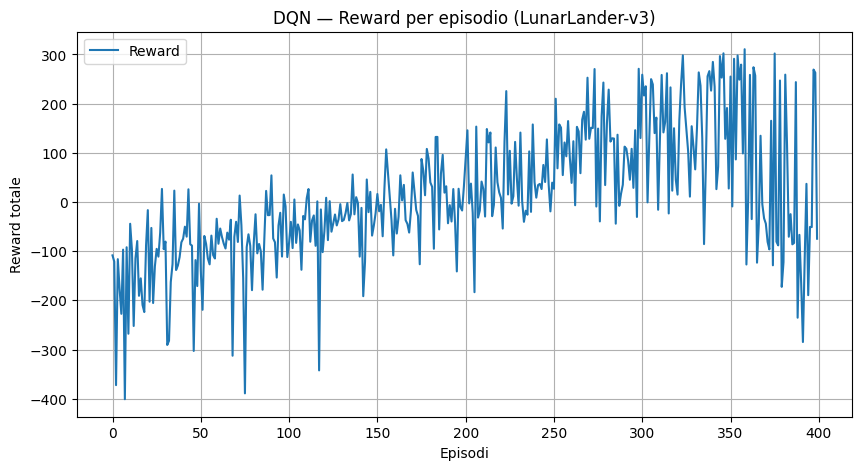

⚙️ Inizializzo rete: QNetwork (classico, double o PER)
🎬 Registrazione progressiva per DQN — 5 checkpoint trovati


Registrazione dqn:  20%|███████▏                            | 1/5 [00:00<00:03,  1.23it/s]

🎞️ dqn_ep000_-113.9.mp4 — reward -113.9 (84 frames)


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
Registrazione dqn:  40%|██████████████▍                     | 2/5 [00:08<00:14,  4.93s/it]

🎞️ dqn_ep100_-328.1.mp4 — reward -328.1 (1000 frames)


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
Registrazione dqn:  60%|█████████████████████▌              | 3/5 [00:11<00:07,  3.85s/it]

🎞️ dqn_ep200_190.4.mp4 — reward 190.4 (568 frames)


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
Registrazione dqn:  80%|████████████████████████████▊       | 4/5 [00:14<00:03,  3.45s/it]

🎞️ dqn_ep300_-19.3.mp4 — reward -19.3 (1000 frames)


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
Registrazione dqn: 100%|████████████████████████████████████| 5/5 [00:14<00:00,  2.89s/it]

🎞️ dqn_ep400_-78.2.mp4 — reward -78.2 (112 frames)
✅ JSON salvato in experiments/lunarlander/static/videos\dqn_progress.json
🎬 Totale video generati: 5


In [56]:
# === 🏋️ TRAINING DQN ===
EPISODES = config["episodes"]
BATCH    = config["batch_size"]
GAMMA    = config["gamma"]


MODELS_DIR = os.path.join("experiments", "lunarlander", "models")
os.makedirs(MODELS_DIR, exist_ok=True)


rewards_history = []
loss_history = []
global_step = 0

pbar = tqdm(range(EPISODES), desc="Training DQN")

for ep in pbar:
    epsilon = epsilon_by_episode(ep, config["epsilon_start"], config["epsilon_end"], config["epsilon_decay"])
    state, _ = env.reset(seed=SEED + ep)
    done = False
    ep_reward = 0.0
    ep_losses = []

    for t in range(config["max_steps"]):
        # Azione ε-greedy
        action = select_action(policy_net, state, epsilon)

        # Step ambiente (Gymnasium API)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        # Salva transizione
        memory.push(state, action, reward, next_state, float(done))

        # Ottimizza su mini-batch
        loss_val = optimize_model(memory, policy_net, target_net, optimizer, BATCH, GAMMA)
        if loss_val is not None:
            ep_losses.append(loss_val)

        state = next_state
        ep_reward += reward
        global_step += 1

        # Sync hard della target net ogni N passi (stabile su LunarLander)
        if global_step % config["update_target_every"] == 0:
            hard_update(policy_net, target_net)

        if done:
            break

    rewards_history.append(ep_reward)
    if ep_losses:
        loss_history.append(np.mean(ep_losses))
    else:
        loss_history.append(np.nan)

    pbar.set_postfix(eps=f"{epsilon:.3f}", reward=f"{ep_reward:.1f}", loss=f"{loss_history[-1]:.4f}")

        # === 💾 Checkpoint ogni 100 episodi ===
    if (ep + 1) % 100 == 0 or (ep + 1) == EPISODES:
        ckpt_name = f"dqn_ep{ep+1:03d}.pth"
        ckpt_path = os.path.join(MODELS_DIR, ckpt_name)
        torch.save(policy_net.state_dict(), ckpt_path)
        print(f"🧠 Checkpoint salvato: {ckpt_path}")


# Salvataggi
save_results_csv(rewards_history, "rewards_dqn.csv")
save_model(policy_net, "dqn.pth")

# Plot veloce
plot_rewards(rewards_history, title="DQN — Reward per episodio (LunarLander-v3)")


record_learning_progress("dqn", env_name="LunarLander-v3")
 





In [57]:
# === 🧪 VALUTAZIONE GREEDY ===
def evaluate_policy(env, policy_net, episodes=20, max_steps=1000):
    device = config["device"]
    policy_net.eval()
    scores = []
    with torch.no_grad():
        for i in range(episodes):
            s, _ = env.reset(seed=SEED + 1000 + i)
            done = False
            ep_ret = 0.0
            for t in range(max_steps):
                s_t = torch.from_numpy(s).float().unsqueeze(0).to(device)
                a = int(torch.argmax(policy_net(s_t), dim=1).item())
                s, r, terminated, truncated, _ = env.step(a)
                ep_ret += r
                if terminated or truncated:
                    break
            scores.append(ep_ret)
    policy_net.train()
    return {
        "mean": float(np.mean(scores)),
        "std":  float(np.std(scores)),
        "min":  float(np.min(scores)),
        "max":  float(np.max(scores)),
        "n_episodes": episodes,
        "scores": list(map(float, scores)),
    }

eval_stats = evaluate_policy(env, policy_net, episodes=20, max_steps=config["max_steps"])
eval_path = os.path.join(RESULTS_DIR, "eval_dqn.json")
with open(eval_path, "w") as f:
    json.dump(eval_stats, f, indent=2)
print(f"🧾 Valutazione salvata: {eval_path}")
print("📊 DQN — mean reward (greedy):", eval_stats["mean"])


🧾 Valutazione salvata: experiments/lunarlander\results\eval_dqn.json
📊 DQN — mean reward (greedy): 37.20475535400905


In [58]:
# === 🔗 EXPORT FRONTEND (payload minimale) ===
payload = {
    "algorithm": "DQN",
    "env": ENV_NAME,
    "config": config,
    "training": {
        "episodes": len(rewards_history),
        "rewards": list(map(float, rewards_history)),
        "loss": list(map(lambda x: None if np.isnan(x) else float(x), loss_history)),
    },
    "evaluation": eval_stats,
}

frontend_dir = os.path.join("frontend", "static", "data")
os.makedirs(frontend_dir, exist_ok=True)
json_path = os.path.join(frontend_dir, "lunarlander_dqn.json")
with open(json_path, "w") as f:
    json.dump(payload, f)
print(f"🌐 Esportato per frontend: {json_path}")


🌐 Esportato per frontend: frontend\static\data\lunarlander_dqn.json


In [59]:
# === 🧠 Double DQN — ottimizzazione ===
def optimize_model_double(memory, policy_net, target_net, optimizer, batch_size, gamma):
    if len(memory) < batch_size:
        return None

    states, actions, rewards, next_states, dones = memory.sample(batch_size)
    device = config["device"]

    states      = states.to(device)
    actions     = actions.to(device).unsqueeze(1)
    rewards     = rewards.to(device).unsqueeze(1)
    next_states = next_states.to(device)
    dones       = dones.to(device).unsqueeze(1)

    # Q(s,a) corrente
    q_values = policy_net(states).gather(1, actions)

    # Double DQN target: seleziona con online, valuta con target
    with torch.no_grad():
        next_actions = policy_net(next_states).argmax(1, keepdim=True)      # scelta
        next_q = target_net(next_states).gather(1, next_actions)            # valutazione
        target = rewards + (1.0 - dones) * gamma * next_q

    loss = F.smooth_l1_loss(q_values, target)

    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(policy_net.parameters(), max_norm=10.0)
    optimizer.step()

    return loss.item()


🚀 Avvio training Double DQN...


Training Double DQN:  25%|████████████████████▎                                                            | 100/400 [00:23<01:53,  2.64it/s, eps=0.609, loss=1.3052, reward=-23.9]

🧠 Checkpoint salvato: experiments\lunarlander\models\dueling_ep100.pth


Training Double DQN:  50%|████████████████████████████████████████▌                                        | 200/400 [05:24<25:33,  7.67s/it, eps=0.369, loss=1.8858, reward=-27.5]

🧠 Checkpoint salvato: experiments\lunarlander\models\dueling_ep200.pth


Training Double DQN:  75%|████████████████████████████████████████████████████████████▊                    | 300/400 [17:11<14:07,  8.48s/it, eps=0.223, loss=1.2796, reward=166.1]

🧠 Checkpoint salvato: experiments\lunarlander\models\dueling_ep300.pth


Training Double DQN: 100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [27:50<00:00,  4.18s/it, eps=0.135, loss=0.4412, reward=141.9]


🧠 Checkpoint salvato: experiments\lunarlander\models\dueling_ep400.pth
💾 Salvato: experiments/lunarlander\results\rewards_double.csv
🧠 Modello salvato: experiments\lunarlander\models\double.pth


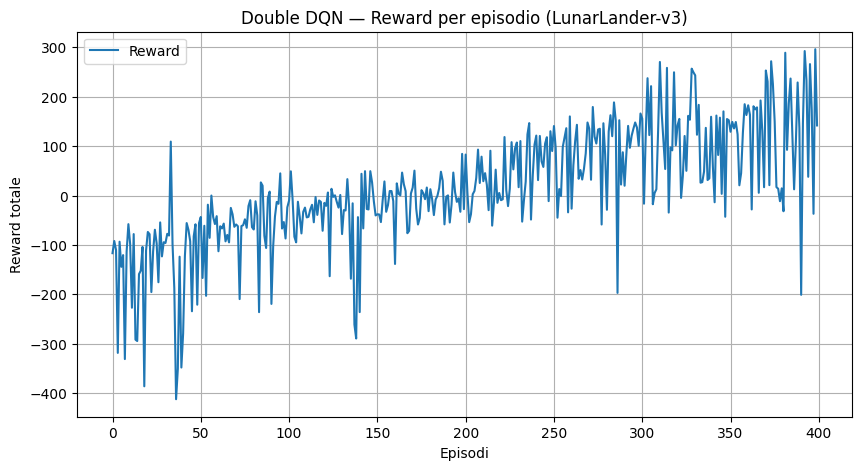

⚙️ Inizializzo rete: QNetwork (classico, double o PER)
🎬 Registrazione progressiva per DOUBLE — 1 checkpoint trovati


Registrazione double: 100%|█████████████████████████████████| 1/1 [00:01<00:00,  1.46s/it]

🎞️ double_ep000_252.9.mp4 — reward 252.9 (196 frames)
✅ JSON salvato in experiments/lunarlander/static/videos\double_progress.json
🎬 Totale video generati: 1


In [60]:
# === 🏋️ TRAINING DOUBLE DQN ===
policy_net_double = QNetwork(state_dim, action_dim).to(config["device"])
target_net_double = QNetwork(state_dim, action_dim).to(config["device"])
target_net_double.load_state_dict(policy_net_double.state_dict())
target_net_double.eval()
optimizer_double = optim.Adam(policy_net_double.parameters(), lr=config["learning_rate"])
memory_double = ReplayBuffer(config["buffer_size"])

rewards_double = []
losses_double = []
global_step = 0

print("🚀 Avvio training Double DQN...")
pbar = tqdm(range(config["episodes"]), desc="Training Double DQN")

for ep in pbar:
    epsilon = epsilon_by_episode(ep, config["epsilon_start"], config["epsilon_end"], config["epsilon_decay"])
    state, _ = env.reset(seed=SEED + 500 + ep)
    done = False
    ep_reward = 0.0
    ep_losses = []

    for t in range(config["max_steps"]):
        action = select_action(policy_net_double, state, epsilon)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        memory_double.push(state, action, reward, next_state, float(done))

        loss_val = optimize_model_double(memory_double, policy_net_double, target_net_double,
                                         optimizer_double, config["batch_size"], config["gamma"])
        if loss_val is not None:
            ep_losses.append(loss_val)

        state = next_state
        ep_reward += reward
        global_step += 1

        if global_step % config["update_target_every"] == 0:
            hard_update(policy_net_double, target_net_double)

        if done:
            break

    rewards_double.append(ep_reward)
    losses_double.append(np.mean(ep_losses) if ep_losses else np.nan)
    pbar.set_postfix(eps=f"{epsilon:.3f}", reward=f"{ep_reward:.1f}", loss=f"{losses_double[-1]:.4f}")
        # === 💾 Checkpoint ogni 100 episodi ===
    if (ep + 1) % 100 == 0 or (ep + 1) == config["episodes"]:
        ckpt_name = f"dueling_ep{ep+1:03d}.pth"
        ckpt_path = os.path.join(MODELS_DIR, ckpt_name)
        torch.save(policy_net_duel.state_dict(), ckpt_path)
        print(f"🧠 Checkpoint salvato: {ckpt_path}")


# Salvataggi
save_results_csv(rewards_double, "rewards_double.csv")
save_model(policy_net_double, "double.pth")

plot_rewards(rewards_double, title="Double DQN — Reward per episodio (LunarLander-v3)")

record_learning_progress("double", env_name="LunarLander-v3")









In [61]:
# === 🧪 VALUTAZIONE GREEDY DOUBLE DQN ===
eval_stats_double = evaluate_policy(env, policy_net_double, episodes=20, max_steps=config["max_steps"])
eval_path = os.path.join(RESULTS_DIR, "eval_double.json")
with open(eval_path, "w") as f:
    json.dump(eval_stats_double, f, indent=2)
print(f"🧾 Valutazione salvata: {eval_path}")
print("📊 Double DQN — mean reward (greedy):", eval_stats_double["mean"])


🧾 Valutazione salvata: experiments/lunarlander\results\eval_double.json
📊 Double DQN — mean reward (greedy): 87.88584806141907


In [62]:
# === 🔗 EXPORT FRONTEND — Double DQN ===
payload_double = {
    "algorithm": "Double DQN",
    "env": ENV_NAME,
    "config": config,
    "training": {
        "episodes": len(rewards_double),
        "rewards": list(map(float, rewards_double)),
        "loss": list(map(lambda x: None if np.isnan(x) else float(x), losses_double)),
    },
    "evaluation": eval_stats_double,
}

frontend_dir = os.path.join("frontend", "static", "data")
os.makedirs(frontend_dir, exist_ok=True)
json_path = os.path.join(frontend_dir, "lunarlander_double.json")
with open(json_path, "w") as f:
    json.dump(payload_double, f)
print(f"🌐 Esportato per frontend: {json_path}")


🌐 Esportato per frontend: frontend\static\data\lunarlander_double.json


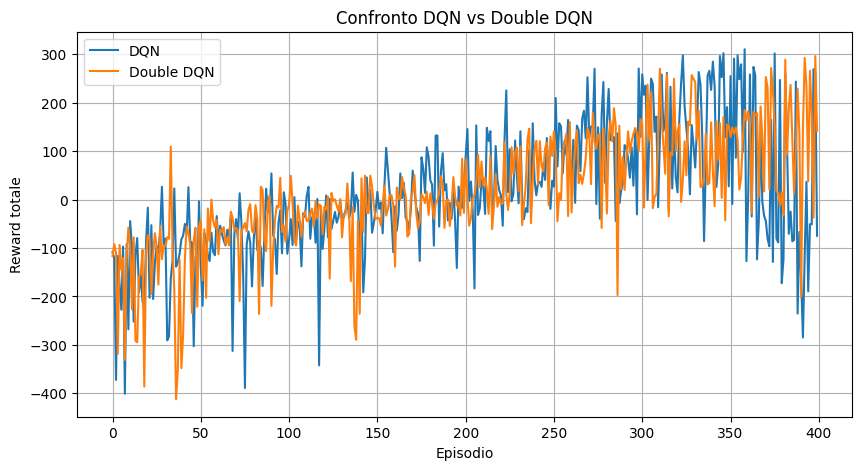

In [63]:
plt.figure(figsize=(10,5))
plt.plot(rewards_history, label="DQN")
plt.plot(rewards_double, label="Double DQN")
plt.xlabel("Episodio")
plt.ylabel("Reward totale")
plt.title("Confronto DQN vs Double DQN")
plt.legend()
plt.grid(True)
plt.show()


In [64]:
# === 🧠 Dueling Q-Network ===
class DuelingQNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DuelingQNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)

        # Flusso valore e flusso vantaggio
        self.value_stream = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        self.advantage_stream = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        value = self.value_stream(x)
        advantage = self.advantage_stream(x)
        q = value + (advantage - advantage.mean(dim=1, keepdim=True))
        return q


🚀 Avvio training Dueling DQN...


Training Dueling DQN:  25%|████████████████████                                                            | 100/400 [03:19<16:33,  3.31s/it, eps=0.609, loss=1.2159, reward=-39.8]

🧠 Checkpoint salvato: experiments\lunarlander\models\dueling_ep100.pth


Training Dueling DQN:  50%|████████████████████████████████████████                                        | 200/400 [13:43<21:51,  6.56s/it, eps=0.369, loss=1.6201, reward=-28.5]

🧠 Checkpoint salvato: experiments\lunarlander\models\dueling_ep200.pth


Training Dueling DQN:  75%|█████████████████████████████████████████████████████████████▌                    | 300/400 [25:38<06:29,  3.89s/it, eps=0.223, loss=1.0865, reward=0.4]

🧠 Checkpoint salvato: experiments\lunarlander\models\dueling_ep300.pth


Training Dueling DQN: 100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [37:55<00:00,  5.69s/it, eps=0.135, loss=0.6245, reward=43.8]


🧠 Checkpoint salvato: experiments\lunarlander\models\dueling_ep400.pth
💾 Salvato: experiments/lunarlander\results\rewards_dueling.csv
🧠 Modello salvato: experiments\lunarlander\models\dueling.pth


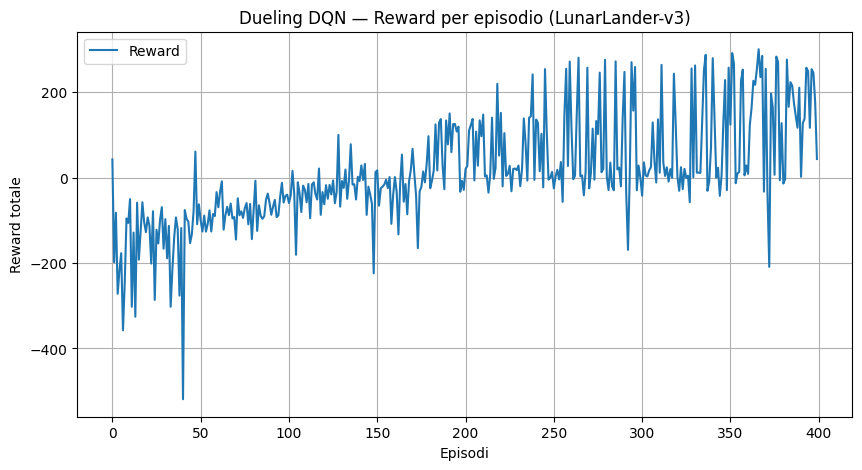

In [65]:
# === 🏋️ TRAINING DUELING DQN ===
policy_net_duel = DuelingQNetwork(state_dim, action_dim).to(config["device"])
target_net_duel = DuelingQNetwork(state_dim, action_dim).to(config["device"])
target_net_duel.load_state_dict(policy_net_duel.state_dict())
target_net_duel.eval()
optimizer_duel = optim.Adam(policy_net_duel.parameters(), lr=config["learning_rate"])
memory_duel = ReplayBuffer(config["buffer_size"])

rewards_duel = []
losses_duel = []
global_step = 0

print("🚀 Avvio training Dueling DQN...")
pbar = tqdm(range(config["episodes"]), desc="Training Dueling DQN")

for ep in pbar:
    epsilon = epsilon_by_episode(ep, config["epsilon_start"], config["epsilon_end"], config["epsilon_decay"])
    state, _ = env.reset(seed=SEED + 800 + ep)
    done = False
    ep_reward = 0.0
    ep_losses = []

    for t in range(config["max_steps"]):
        action = select_action(policy_net_duel, state, epsilon)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        memory_duel.push(state, action, reward, next_state, float(done))

        loss_val = optimize_model(memory_duel, policy_net_duel, target_net_duel,
                                  optimizer_duel, config["batch_size"], config["gamma"])
        if loss_val is not None:
            ep_losses.append(loss_val)

        state = next_state
        ep_reward += reward
        global_step += 1

        if global_step % config["update_target_every"] == 0:
            hard_update(policy_net_duel, target_net_duel)

        if done:
            break

    rewards_duel.append(ep_reward)
    losses_duel.append(np.mean(ep_losses) if ep_losses else np.nan)
    pbar.set_postfix(eps=f"{epsilon:.3f}", reward=f"{ep_reward:.1f}", loss=f"{losses_duel[-1]:.4f}")

    if (ep + 1) % 100 == 0 or (ep + 1) == config["episodes"]:
        ckpt_name = f"dueling_ep{ep+1:03d}.pth"
        ckpt_path = os.path.join(MODELS_DIR, ckpt_name)
        torch.save(policy_net_duel.state_dict(), ckpt_path)
        print(f"🧠 Checkpoint salvato: {ckpt_path}")

# Salvataggi
save_results_csv(rewards_duel, "rewards_dueling.csv")
save_model(policy_net_duel, "dueling.pth")

plot_rewards(rewards_duel, title="Dueling DQN — Reward per episodio (LunarLander-v3)")









In [66]:
record_learning_progress("dueling", env_name="LunarLander-v3")


⚙️ Inizializzo rete: DuelingQNetwork
🎬 Registrazione progressiva per DUELING — 5 checkpoint trovati


Registrazione dueling:  20%|██████▍                         | 1/5 [00:01<00:07,  1.79s/it]

🎞️ dueling_ep000_258.9.mp4 — reward 258.9 (244 frames)


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
Registrazione dueling:  40%|████████████▊                   | 2/5 [00:06<00:09,  3.32s/it]

🎞️ dueling_ep100_-284.9.mp4 — reward -284.9 (648 frames)


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
Registrazione dueling:  60%|███████████████████▏            | 3/5 [00:08<00:05,  2.73s/it]

🎞️ dueling_ep200_209.8.mp4 — reward 209.8 (292 frames)


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
Registrazione dueling:  80%|█████████████████████████▌      | 4/5 [00:10<00:02,  2.75s/it]

🎞️ dueling_ep300_182.1.mp4 — reward 182.1 (407 frames)


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
Registrazione dueling: 100%|████████████████████████████████| 5/5 [00:12<00:00,  2.55s/it]

🎞️ dueling_ep400_267.9.mp4 — reward 267.9 (235 frames)
✅ JSON salvato in experiments/lunarlander/static/videos\dueling_progress.json
🎬 Totale video generati: 5


In [67]:
# === 🧪 VALUTAZIONE GREEDY DUELING DQN ===
eval_stats_duel = evaluate_policy(env, policy_net_duel, episodes=20, max_steps=config["max_steps"])
eval_path = os.path.join(RESULTS_DIR, "eval_dueling.json")
with open(eval_path, "w") as f:
    json.dump(eval_stats_duel, f, indent=2)
print(f"🧾 Valutazione salvata: {eval_path}")
print("📊 Dueling DQN — mean reward (greedy):", eval_stats_duel["mean"])


🧾 Valutazione salvata: experiments/lunarlander\results\eval_dueling.json
📊 Dueling DQN — mean reward (greedy): 175.43808915279791


In [68]:
# === 🔗 EXPORT FRONTEND — Dueling DQN ===
payload_duel = {
    "algorithm": "Dueling DQN",
    "env": ENV_NAME,
    "config": config,
    "training": {
        "episodes": len(rewards_duel),
        "rewards": list(map(float, rewards_duel)),
        "loss": list(map(lambda x: None if np.isnan(x) else float(x), losses_duel)),
    },
    "evaluation": eval_stats_duel,
}

frontend_dir = os.path.join("frontend", "static", "data")
os.makedirs(frontend_dir, exist_ok=True)
json_path = os.path.join(frontend_dir, "lunarlander_dueling.json")
with open(json_path, "w") as f:
    json.dump(payload_duel, f)
print(f"🌐 Esportato per frontend: {json_path}")


🌐 Esportato per frontend: frontend\static\data\lunarlander_dueling.json


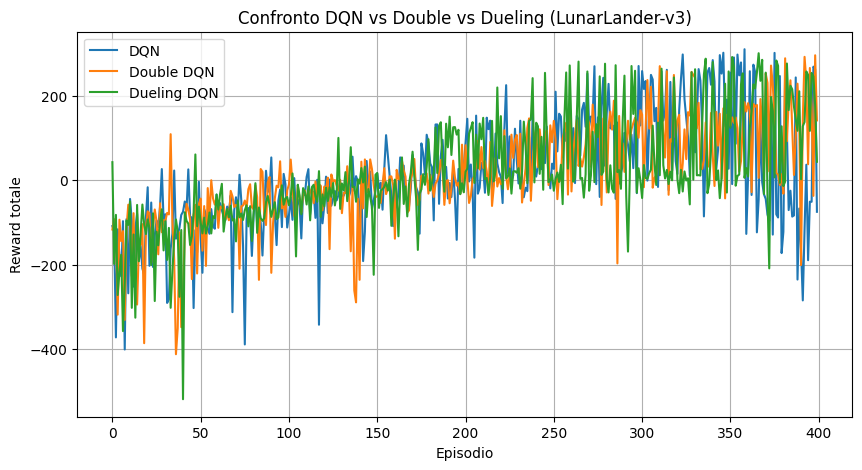

In [69]:
plt.figure(figsize=(10,5))
plt.plot(rewards_history, label="DQN")
plt.plot(rewards_double, label="Double DQN")
plt.plot(rewards_duel, label="Dueling DQN")
plt.xlabel("Episodio")
plt.ylabel("Reward totale")
plt.title("Confronto DQN vs Double vs Dueling (LunarLander-v3)")
plt.legend()
plt.grid(True)
plt.show()


In [70]:
# === 🎯 Prioritized Replay Buffer (proportional) ===
class SumTree:
    # Segment tree (sum) per sampling O(log N)
    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = np.zeros(2 * capacity, dtype=np.float32)  # 1-based (we'll ignore 0)
        self.data = np.empty(capacity, dtype=object)
        self.write = 0
        self.n_entries = 0

    def _update(self, idx, change):
        while idx > 0:
            self.tree[idx] += change
            idx //= 2

    def update(self, idx, priority):
        # idx è foglia: [capacity .. capacity+capacity-1]
        change = priority - self.tree[idx]
        self._update(idx, change)

    def add(self, priority, data):
        idx = self.write + self.capacity
        self.data[self.write] = data
        self.update(idx, priority)
        self.write = (self.write + 1) % self.capacity
        self.n_entries = min(self.n_entries + 1, self.capacity)

    def get(self, s):
        # trova il primo idx tale che somma cumulativa >= s
        idx = 1
        while idx < self.capacity:
            left = 2 * idx
            if self.tree[left] >= s:
                idx = left
            else:
                s -= self.tree[left]
                idx = left + 1
        data_idx = idx - self.capacity
        return idx, self.tree[idx], self.data[data_idx]

    @property
    def total(self):
        return self.tree[1]


class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6, beta_start=0.4, beta_frames=200_000, eps=1e-5):
        self.tree = SumTree(capacity)
        self.alpha = alpha
        self.beta_start = beta_start
        self.beta_frames = beta_frames
        self.frame = 1
        self.eps = eps
        self.max_priority = 1.0

    def beta_by_frame(self):
        return min(1.0, self.beta_start + (1.0 - self.beta_start) * (self.frame / self.beta_frames))

    def push(self, state, action, reward, next_state, done):
        data = (state, action, reward, next_state, done)
        priority = self.max_priority ** self.alpha
        self.tree.add(priority, data)

    def sample(self, batch_size):
        batch, idxs, priorities = [], [], []
        segment = max(self.tree.total / batch_size, 1e-6)
    
        for i in range(batch_size):
            s = random.random() * segment + i * segment
            idx, p, data = self.tree.get(s)
    
            # Skip se l’elemento è None o non inizializzato
            if data is None:
                continue
    
            batch.append(data)
            idxs.append(idx)
            priorities.append(p)
    
        # Se non abbiamo abbastanza transizioni valide, ritorna None
        if len(batch) < 1:
            return None
    
        # Conversione in array NumPy
        try:
            states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
        except Exception as e:
            print(f"⚠️ Errore nel batch PER: {e} — skip batch")
            return None
    
        # Probabilità di campionamento
        probs = np.array(priorities) / (self.tree.total + 1e-8)
    
        # Calcolo pesi IS
        beta = self.beta_by_frame()
        weights = (self.tree.n_entries * probs) ** (-beta)
        weights /= weights.max() + 1e-8
    
        # Avanza contatore
        self.frame += 1
    
        return (
            torch.FloatTensor(states),
            torch.LongTensor(actions),
            torch.FloatTensor(rewards),
            torch.FloatTensor(next_states),
            torch.FloatTensor(dones),
            torch.FloatTensor(weights),
            np.array(idxs, dtype=np.int32)
        )


    def update_priorities(self, idxs, td_errors):
        # priorità = (|δ| + eps)^alpha
        priorities = (np.abs(td_errors) + self.eps) ** self.alpha
        for idx, prio in zip(idxs, priorities):
            self.tree.update(int(idx), float(prio))
            self.max_priority = max(self.max_priority, float(prio))

    def __len__(self):
        return self.tree.n_entries


In [71]:
# === 🧮 Optimize step per PER ===
def optimize_model_per(memory_per, policy_net, target_net, optimizer, batch_size, gamma):
    if len(memory_per) < batch_size:
        return None, None, None

    (states, actions, rewards, next_states, dones, weights, idxs) = memory_per.sample(batch_size)
    device = config["device"]

    states      = states.to(device)
    actions     = actions.to(device).unsqueeze(1)
    rewards     = rewards.to(device).unsqueeze(1)
    next_states = next_states.to(device)
    dones       = dones.to(device).unsqueeze(1)
    weights     = weights.to(device).unsqueeze(1)

    # Q(s,a) corrente
    q_values = policy_net(states).gather(1, actions)

    with torch.no_grad():
        next_q = target_net(next_states).max(dim=1, keepdim=True)[0]
        target = rewards + (1.0 - dones) * gamma * next_q

    td_errors = (q_values - target).detach().cpu().numpy().squeeze()
    loss = (weights * F.smooth_l1_loss(q_values, target, reduction='none')).mean()

    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(policy_net.parameters(), max_norm=10.0)
    optimizer.step()

    return loss.item(), td_errors, idxs


🚀 Avvio training DQN + PER...


Training DQN + PER:   0%|                                                                                                                                  | 0/400 [00:00<?, ?it/s]

Warm-up iniziale del buffer PER...
Buffer PER inizializzato con 584 esperienze



Training DQN + PER:  25%|████████████████████▌                                                             | 100/400 [01:56<06:01,  1.20s/it, eps=0.609, loss=1.1531, reward=-76.2]

🧠 Checkpoint salvato: experiments\lunarlander\models\per_ep100.pth


Training DQN + PER:  50%|█████████████████████████████████████████                                         | 200/400 [06:47<08:52,  2.66s/it, eps=0.369, loss=1.4177, reward=-37.4]

🧠 Checkpoint salvato: experiments\lunarlander\models\per_ep200.pth


Training DQN + PER:  75%|█████████████████████████████████████████████████████████████▌                    | 300/400 [19:52<16:00,  9.61s/it, eps=0.223, loss=0.4584, reward=110.3]

🧠 Checkpoint salvato: experiments\lunarlander\models\per_ep300.pth


Training DQN + PER: 100%|███████████████████████████████████████████████████████████████████████████████████| 400/400 [35:30<00:00,  5.33s/it, eps=0.135, loss=0.1357, reward=43.5]


🧠 Checkpoint salvato: experiments\lunarlander\models\per_ep400.pth
💾 Salvato: experiments/lunarlander\results\rewards_per.csv
🧠 Modello salvato: experiments\lunarlander\models\per.pth


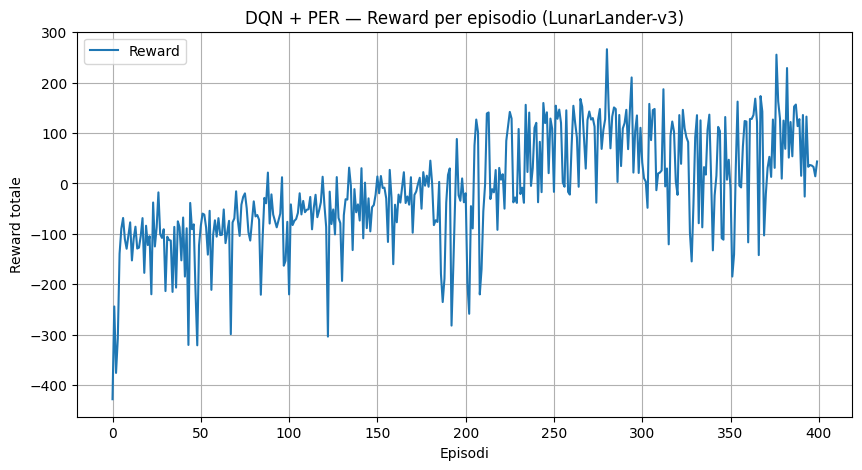

⚙️ Inizializzo rete: QNetwork (classico, double o PER)
🎬 Registrazione progressiva per PER — 5 checkpoint trovati


Registrazione per:  20%|███████▏                            | 1/5 [00:02<00:11,  2.80s/it]

🎞️ per_ep000_259.5.mp4 — reward 259.5 (240 frames)


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
Registrazione per:  40%|██████████████▍                     | 2/5 [00:14<00:24,  8.18s/it]

🎞️ per_ep100_-135.6.mp4 — reward -135.6 (1000 frames)


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
Registrazione per:  60%|█████████████████████▌              | 3/5 [00:38<00:30, 15.17s/it]

🎞️ per_ep200_-310.3.mp4 — reward -310.3 (897 frames)


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
Registrazione per:  80%|████████████████████████████▊       | 4/5 [00:47<00:12, 12.65s/it]

🎞️ per_ep300_256.4.mp4 — reward 256.4 (290 frames)


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
Registrazione per: 100%|████████████████████████████████████| 5/5 [00:49<00:00,  9.82s/it]

🎞️ per_ep400_34.1.mp4 — reward 34.1 (132 frames)
✅ JSON salvato in experiments/lunarlander/static/videos\per_progress.json
🎬 Totale video generati: 5


In [72]:
# === 🏋️ TRAINING DQN con PER ===
policy_net_per = QNetwork(state_dim, action_dim).to(config["device"])
target_net_per = QNetwork(state_dim, action_dim).to(config["device"])
target_net_per.load_state_dict(policy_net_per.state_dict())
target_net_per.eval()
optimizer_per = optim.Adam(policy_net_per.parameters(), lr=config["learning_rate"])

per_alpha = 0.6    # tipico 0.6
per_beta0 = 0.4    # parte da 0.4 e anneal → 1.0
memory_per = PrioritizedReplayBuffer(config["buffer_size"], alpha=per_alpha, beta_start=per_beta0, beta_frames=200_000)

rewards_per = []
losses_per = []
global_step = 0

print("🚀 Avvio training DQN + PER...")
pbar = tqdm(range(config["episodes"]), desc="Training DQN + PER")


# 🔥 Warm-up iniziale del buffer PER
print("Warm-up iniziale del buffer PER...")
for _ in range(5):  # 5 episodi casuali
    s, _ = env.reset(seed=SEED)
    done = False
    while not done:
        a = env.action_space.sample()
        s2, r, terminated, truncated, _ = env.step(a)
        done = terminated or truncated
        memory_per.push(s, a, r, s2, float(done))
        s = s2
print(f"Buffer PER inizializzato con {len(memory_per)} esperienze\n")


for ep in pbar:
    epsilon = epsilon_by_episode(ep, config["epsilon_start"], config["epsilon_end"], config["epsilon_decay"])
    state, _ = env.reset(seed=SEED + 1100 + ep)
    done = False
    ep_reward = 0.0
    ep_losses = []

    for t in range(config["max_steps"]):
        # ε-greedy
        action = select_action(policy_net_per, state, epsilon)

        # step ambiente
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        # push transizione
        memory_per.push(state, action, reward, next_state, float(done))

        # optimize con PER (se buffer abbastanza pieno)
        loss_val, td_errs, idxs = optimize_model_per(memory_per, policy_net_per, target_net_per,
                                                     optimizer_per, config["batch_size"], config["gamma"])
       
        if loss_val is not None:
            ep_losses.append(loss_val)
            if td_errs is not None and idxs is not None:
                memory_per.update_priorities(idxs, td_errs)


        state = next_state
        ep_reward += reward
        global_step += 1

        if global_step % config["update_target_every"] == 0:
            hard_update(policy_net_per, target_net_per)

        if done:
            break

    rewards_per.append(ep_reward)
    losses_per.append(np.mean(ep_losses) if ep_losses else np.nan)
    pbar.set_postfix(eps=f"{epsilon:.3f}", reward=f"{ep_reward:.1f}", loss=f"{losses_per[-1]:.4f}")


    if (ep + 1) % 100 == 0 or (ep + 1) == config["episodes"]:
        ckpt_name = f"per_ep{ep+1:03d}.pth"
        ckpt_path = os.path.join(MODELS_DIR, ckpt_name)
        torch.save(policy_net_per.state_dict(), ckpt_path)
        print(f"🧠 Checkpoint salvato: {ckpt_path}")

# Salvataggi
save_results_csv(rewards_per, "rewards_per.csv")
save_model(policy_net_per, "per.pth")

plot_rewards(rewards_per, title="DQN + PER — Reward per episodio (LunarLander-v3)")


record_learning_progress("per", env_name="LunarLander-v3")



In [73]:
# === 🧪 VALUTAZIONE GREEDY — DQN + PER ===
eval_stats_per = evaluate_policy(env, policy_net_per, episodes=20, max_steps=config["max_steps"])
eval_path = os.path.join(RESULTS_DIR, "eval_per.json")
with open(eval_path, "w") as f:
    json.dump(eval_stats_per, f, indent=2)
print(f"🧾 Valutazione salvata: {eval_path}")
print("📊 DQN + PER — mean reward (greedy):", eval_stats_per["mean"])


🧾 Valutazione salvata: experiments/lunarlander\results\eval_per.json
📊 DQN + PER — mean reward (greedy): 211.2642719874654


In [74]:
# === 🔗 EXPORT FRONTEND — DQN + PER ===
payload_per = {
    "algorithm": "DQN + Prioritized Replay",
    "env": ENV_NAME,
    "config": {**config, "per_alpha": per_alpha, "per_beta0": per_beta0},
    "training": {
        "episodes": len(rewards_per),
        "rewards": list(map(float, rewards_per)),
        "loss": list(map(lambda x: None if np.isnan(x) else float(x), losses_per)),
    },
    "evaluation": eval_stats_per,
}

frontend_dir = os.path.join("frontend", "static", "data")
os.makedirs(frontend_dir, exist_ok=True)
json_path = os.path.join(frontend_dir, "lunarlander_per.json")
with open(json_path, "w") as f:
    json.dump(payload_per, f)
print(f"🌐 Esportato per frontend: {json_path}")


🌐 Esportato per frontend: frontend\static\data\lunarlander_per.json


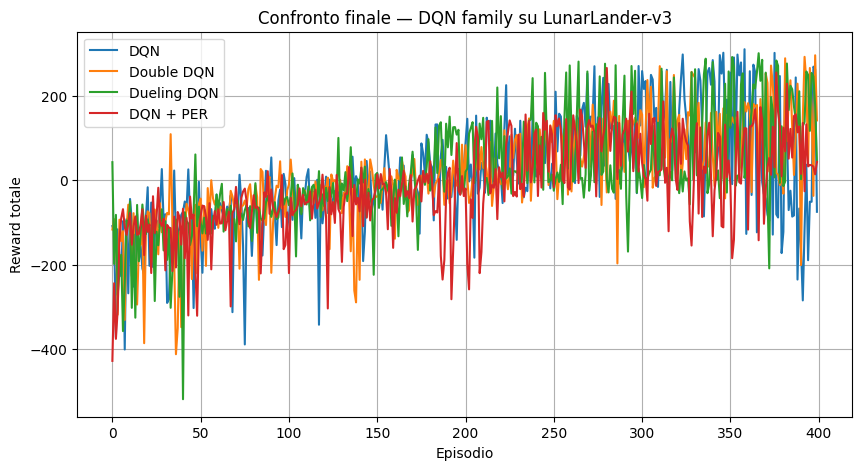

In [75]:
plt.figure(figsize=(10,5))
plt.plot(rewards_history, label="DQN")
plt.plot(rewards_double, label="Double DQN")
plt.plot(rewards_duel, label="Dueling DQN")
plt.plot(rewards_per, label="DQN + PER")
plt.xlabel("Episodio")
plt.ylabel("Reward totale")
plt.title("Confronto finale — DQN family su LunarLander-v3")
plt.legend()
plt.grid(True)
plt.show()


In [76]:
# === 🧾 RIEPILOGO METRICHE FINALI ===
summary = pd.DataFrame([
    {"algorithm": "DQN",              "mean_eval": json.load(open(os.path.join(RESULTS_DIR, "eval_dqn.json")))["mean"]},
    {"algorithm": "Double DQN",       "mean_eval": json.load(open(os.path.join(RESULTS_DIR, "eval_double.json")))["mean"]},
    {"algorithm": "Dueling DQN",      "mean_eval": json.load(open(os.path.join(RESULTS_DIR, "eval_dueling.json")))["mean"]},
    {"algorithm": "DQN + PER",        "mean_eval": json.load(open(os.path.join(RESULTS_DIR, "eval_per.json")))["mean"]},
])
summary_path = os.path.join(RESULTS_DIR, "rewards_summary.csv")
summary.to_csv(summary_path, index=False)
print(f"💾 Riepilogo salvato: {summary_path}")
summary


💾 Riepilogo salvato: experiments/lunarlander\results\rewards_summary.csv


,algorithm,mean_eval
0,DQN,37.204755
1,Double DQN,87.885848
2,Dueling DQN,175.438089
3,DQN + PER,211.264272
